In [1]:
import torch # 파이토치 라이브러리
import torch.nn as nn # 딥러닝 네트워크 기본 구성요소 torch.nn
import torch.nn.functional as F # 자주 사용되는 함수가 포함된 모듈 torch.nn.functional
import torch.optim as optim # 가중치 추정에 필요한 최적화 알고리즘이 있는 torch.optim
from torchvision import datasets, transforms # 딥러닝에서 자주 사용되는 데이터셋과 모델구조 및 이미지 변환 모듈 torchvision

from matplotlib import pyplot as plt # 데이터 시각화
%matplotlib inline

In [2]:
is_cuda = torch.cuda.is_available() # cuda를 사용할 수 있는지 유무 판단
device = torch.device('cuda' if is_cuda else 'cpu')
print('Current cuda device is', device)

Current cuda device is cuda


In [3]:
batch_size = 50 # 모델 가중치를 한 번 업데이트시킬 때 사용하는 샘플 단위 개수
epoch_num = 15 # 학습 데이터를 모두 사용하여 학습하는 기본 단위 횟수
learning_rate = 0.001 # Learning Rate

In [4]:
# 데이터 불러오기
# MNIST(경로, 용도, 다운로드, 전처리)
# 전처리의 경우 PyTorch가 입력을 Tensor를 사용하기 때문에 transforms.ToTensor() 사용
train_data = datasets.MNIST(root = './data', train = True, download = True, transform = transforms.ToTensor())
test_data = datasets.MNIST(root = './data', train = False, download = True, transform = transforms.ToTensor())

print('number of training data: ', len(train_data))
print('number of test data: ', len(test_data))

number of training data:  60000
number of test data:  10000


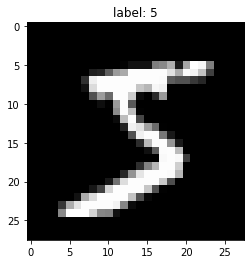

In [5]:
image, label = train_data[0] # 첫 번째 학습 데이터 이미지와 라벨 
plt.imshow(image.squeeze().numpy(), cmap='gray') # squeeze() 함수를 이용해서 2차원으로 전환
plt.title('label: %s' % label)
plt.show()

In [6]:
# 미니배치 구성
# torch.utils.data.DataLoader를 통해서 학습 과정을 반복시행 할 때마다 미니 배치를 하나씩 꺼내온다
# DataLoader(구성할 데이터, 미니 배치 사이즈, 순서를 섞을지)
train_loader = torch.utils.data.DataLoader(dataset = train_data,
                                           batch_size = batch_size,
                                           shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_data,
                                          batch_size = batch_size,
                                          shuffle = True)

# 60000개의 데이터를 50의 배치 사이즈로 나눠서 1200
# 미니 배치의 첫 번째 요소는 4차원 Tensor
# 미니 배치의 두 번째 요소는 미니 배치의 정답
first_batch = train_loader.__iter__().__next__()
print('{:15s} | {:<25s} | {}'.format('name', 'type', 'size'))
print('{:15s} | {:<25s} | {}'.format('Num of Batch', '', len(train_loader)))
print('{:15s} | {:<25s} | {}'.format('first_batch', str(type(first_batch)), len(first_batch)))
print('{:15s} | {:<25s} | {}'.format('first_batch[0]', str(type(first_batch[0])), first_batch[0].shape))
print('{:15s} | {:<25s} | {}'.format('first_batch[1]', str(type(first_batch[1])), first_batch[1].shape))

name            | type                      | size
Num of Batch    |                           | 1200
first_batch     | <class 'list'>            | 2
first_batch[0]  | <class 'torch.Tensor'>    | torch.Size([50, 1, 28, 28])
first_batch[1]  | <class 'torch.Tensor'>    | torch.Size([50])


In [7]:
class CNN(nn.Module): # nn.Module을 상속받는 CNN 클래스 
    def __init__(self): # 가중치를 정의한다
        super(CNN, self).__init__() # nn.Module 클래스의 속성을 상속받고 초기화
        self.conv1 = nn.Conv2d(1, 32, 3, 1) # Convolution Layer (입력 Tensor의 채널, 출력 Tensor의 크기, 필터 크기, stride)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25) # Dropout (확률)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128) # Fully-connected Layer (input vector, output vector)
        self.fc2 = nn.Linear(128, 10)
        
    def forward(self, x): # FeedForward 연산 정의
        x = self.conv1(x) 
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2) # MaxPooling 2*2 size
        x = self.dropout1(x)
        x = torch.flatten(x, 1) # Flatten 1차원으로
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim = 1) # 연산속도를 높힌 log_softmax() 사용
        return output

In [8]:
model = CNN().to(device) # model 인스턴스 생성 및 연산 장비 인식
# 손실 함수를 최소로 하는 가중치를 찾기 위해 Adam 알고리즘의 optimizer 사용
optimizer = optim.Adam(model.parameters(), lr = learning_rate) 
# 다중 클래스 분류 문제기 때문에 Cross Entropy 적용
criterion = nn.CrossEntropyLoss()

In [9]:
print(model) # 모델 구조 확인

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [10]:
model.train() # 학습모드 전환
i = 0 
for epoch in range(epoch_num): # 반복 학습 횟수 epoch_num
    for data, target in train_loader: # 미니 배치를 하나씩 꺼내서 사용
        data = data.to(device) # 데이터를 장비에 할당 
        target = target.to(device) # 정답을 장비에 할당
        optimizer.zero_grad() # 이전 반복 시행에서 저장된 optimizer의 Gradient 초기화
        output = model(data) # 결과값 계산
        loss = criterion(output, target) # 손실함수 계산 
        loss.backward() # 결과를 통해 Gradient 계산
        optimizer.step() # 가중치 업데이트
        if i%1000 == 0:
            print('Train Step: {}\tLoss: {:.3f}'.format(i, loss.item()))
        i += 1

Train Step: 0	Loss: 2.302
Train Step: 1000	Loss: 0.072
Train Step: 2000	Loss: 0.048
Train Step: 3000	Loss: 0.031
Train Step: 4000	Loss: 0.015
Train Step: 5000	Loss: 0.014
Train Step: 6000	Loss: 0.020
Train Step: 7000	Loss: 0.052
Train Step: 8000	Loss: 0.048
Train Step: 9000	Loss: 0.129
Train Step: 10000	Loss: 0.051
Train Step: 11000	Loss: 0.001
Train Step: 12000	Loss: 0.038
Train Step: 13000	Loss: 0.011
Train Step: 14000	Loss: 0.012
Train Step: 15000	Loss: 0.009
Train Step: 16000	Loss: 0.037
Train Step: 17000	Loss: 0.016


In [15]:
model.eval() # 평가모드 전환 / Dropout이 적용되지 않고 Batch-Normalization도 평가모드가 된다
correct = 0 
for data, target in test_loader:
    data = data.to(device)
    target = target.to(device)
    output = model(data)
    prediction = output.data.max(1)[1] # log_softmax 값이 가장 큰 인덱스를 예측값으로 저장
    correct += prediction.eq(target.data).sum() # 미니배치 중 정답의 개수를 구하고 누적으로 더한다
    
print('Test set: Accuracy: {:.2f}%'.format(100 * correct / len(test_loader.dataset))) # 정확도 계산 및 출력

Test set: Accuracy: 99.23%
